In [1]:
import numpy as np
from fish.image.zds import ZDS
from fish.ephys.ephys import load, chop_trials, estimate_onset
import matplotlib.pyplot as plt

In [2]:
def match_cam_time(events, cam, timing, window=None):
    from numpy import array, where
    output = []
    for a in events:
        lags = array([a-b for b in cam])
        before = len(lags[lags > 0]) - 1
        after = before + 1
        
        if (before >= 0) and (after < len(cam)):
            if timing == 'pre':
                if window is None:
                    output.append(before)
                else: 
                    if (window + before)[-1] < len(cam):
                        output.append(before)
            if timing == 'post':
                if window is None:
                    output.append(after)
                else: 
                    if (window + after)[-1] < len(cam):
                        output.append(after)
    return array(output)

In [11]:
base_dir = 'F:/davis/20180328/5dpf_ec43xcy171xcy331_opto_2_20180328_225136/'
ephys_dir = 'R:/davis/data/ephys/20180328/'
epdat = load(ephys_dir + '5dpf_ec43xcy171xcy331_opto_2.10chFlt')
fs_ep = 6000
ims = ZDS(base_dir, parallelism=-1)
fs_im = ims.metadata['volume_rate']

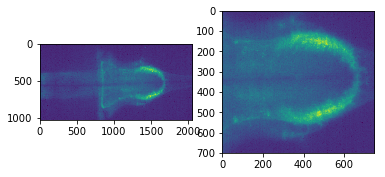

In [12]:
%matplotlib inline
sample = ims[-1]
roi = (slice(None), slice(200, 900), slice(1000, 1750))
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(sample.mean(0), clim=(90, None))

axs[1].imshow(sample[roi].mean(0), clim=(90, None))


In [14]:
trials

{1.0: (array([0], dtype=int64), array([10800206], dtype=int64))}

In [13]:
cam = estimate_onset(epdat[2], 3.7, 300)

trials = chop_trials(epdat[4])
# get rid of condition -1: that's baseline
trials.pop(-1);

window_im = np.arange(np.round(-2 * fs_im), np.round(12 * fs_im), dtype='int') 
onsets_cam = {key : match_cam_time(tr[0], cam, timing='pre', window=window_im) for key, tr in trials.items()}

KeyError: -1

In [ ]:
from skimage.io import imsave
from os.path import exists
from os import makedirs

out_dir = 'F:/davis/20180328/opto_triggering/{0}/'.format(ims.exp_name)

if not exists(out_dir): 
        makedirs(out_dir)

for key in onsets_cam.keys():

    result = np.zeros([len(window_im), len(onsets_cam[key]), *sample[roi].shape], dtype='int16')
    for ind, o in enumerate(onsets_cam[key]):
        result[:,ind] = ims[o + window_im, roi[0], roi[1], roi[2]]
    fname = '{0}_roi_{1}.tif'.format(ims.exp_name, int(key))
    imsave(out_dir + fname, result, imagej=True)
    
np.savez(out_dir + 'window_params.npz', window_im = window_im, roi = roi)